---
# Introduction:

Granberry and Keelan (1) wrote a very useful paper on estimating Critical Water Saturations (Sciw) for any poro-perm combination where Sciw was estimated from relative permeability and fractional flow (fw) at 5% data from the Gulf Coast. This is chart data from a recent PetroWiki document: 

    Estimating permeability based on surface area and water saturation | Society of Petroleum Engineers.pdf

In this document, they did not publish the table, but they did publish the following figure:

![Sciw](Granberry_Keelan_crit_Water.png)

We have digitized this chart and construct a database to lookup the perm for any critical water saturation and porosity. In this example we are using old MRIL B tool data and using MBVI as effective Bulk Volume Irreducible. 

    rho_ma = 2.65
    rho_fl = 1.10
    
    # Density porosity (limestone matrix example; change rho_ma if needed)
    por_den = (rho_ma - merged_df["RHOB"].astype(float)) / (rho_ma - rho_fl)
    
    # Neutron porosity
    npor = merged_df["NPHI"].astype(float)
    
    # Total porosity proxy
    phit = np.sqrt((por_den**2 + npor**2) / 2.0)
    
    # MRIL-B effective porosity (your statement)
    mphi = merged_df["MPHI"].astype(float)
    
    # TE-limited “missing CBW” proxy: only add when PHIT > MPHI
    cbw = np.clip(phit - mphi, 0.0, None)
    
    # MRIL-B bound volume measured above TE cbw cutoff (not total CBW)
    mbvi = merged_df["MBVI"].astype(float)
    
    # Immobile-water volume proxy and Sw proxy
    bvwt = mbvi + cbw
    sw_proxy = bvwt / phit

    phit = phit

    

1) Granberry, R.J., and Keelan, D.K. 1977. Critical Water Estimates for Gulf Coast Sands. Trans., Gulf
Coast Association of Geological Societies 27: 41-43.

---
---

## Python Requirements:

In [1]:
# -*- coding: utf-8 -*-
"""
Used Spyder Editor

"""

"""
===============================================================================
 Import data from text file into a pandas Dataframe called: ``data''.
 Null data (-999.00000) will be replace by numpy.nan and M__DEPTH changed 
 with DEPT (much common abrevation in las files)
===============================================================================
"""
import warnings
warnings.filterwarnings("ignore")


import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

import ipywidgets as widgets

%matplotlib inline

import panel as pn

#Qt4Agg

# Suggested by Hoxbro at Panel
plt.switch_backend("agg")
#plt.switch_backend("Qt4Agg")


pn.extension()

import lasio

from bokeh.models.formatters import PrintfTickFormatter
from bokeh.models.widgets import Button

from scipy.optimize import minimize


## Load Data:
With Geolog we would just pull the data directly from the well, but with this example we are importing the data from a las file.

In [2]:
#las = lasio.read("./data/PHILLIPS.LAS")
las = lasio.read("./data/CHEVRON.LAS")
#las = lasio.read("./data/B2.LAS")


Only engine='normal' can read wrapped files


In [3]:
for item in las.well:
    print(f"{item.descr} ({item.mnemonic}): {item.value}")

START DEPTH (STRT): 5500.0
STOP DEPTH (STOP): 7500.0
STEP (STEP): 0.5
NULL VALUE (NULL): -999.25
COMPANY (COMP): CHEVRON USA PRODUCTION COMPANY
WELL NAME (WELL): OCS-G 1634 NO. BA-5 ST
FIELD (FLD): MAIN PASS 144
LOCATION (LOC): 2911.2 FSL & 6043.1 FEL
LOCATION (LOC2): OF MAIN PASS 144
COUNTY (CNTY): OFFSHORE
STATE (STAT): LA
COUNTRY (CTRY): US OF A
API NUMBER (API): 17 725 40296
SERVICE COMPANY (SRVC): PetCom, Inc.
DATE (DATE): 14-MAR-96 @ 10:10:23


In [4]:
for curve in las.curves:
    print(curve.mnemonic)

DEPTH
GR
NPHI
RHOB
SFLU
ILM
ILD
SP
CALI
MBVI
MGR
MPERM
MPHI
P1
P2
P3
P4
P5
P6
P7
P8
MFFI


In [5]:
for count, curve in enumerate(las.curves):
    print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
print(f"There are a total of: {count+1} curves present within this file")

Curve: DEPTH, Units: FT, Description: Curve #   1
Curve: GR, Units: , Description: Curve #   2
Curve: NPHI, Units: , Description: Curve #   3
Curve: RHOB, Units: , Description: Curve #   4
Curve: SFLU, Units: , Description: Curve #   5
Curve: ILM, Units: , Description: Curve #   6
Curve: ILD, Units: , Description: Curve #   7
Curve: SP, Units: , Description: Curve #   8
Curve: CALI, Units: , Description: Curve #   9
Curve: MBVI, Units: , Description: Curve #  10
Curve: MGR, Units: , Description: Curve #  11
Curve: MPERM, Units: , Description: Curve #  12
Curve: MPHI, Units: , Description: Curve #  13
Curve: P1, Units: , Description: Curve #  14
Curve: P2, Units: , Description: Curve #  15
Curve: P3, Units: , Description: Curve #  16
Curve: P4, Units: , Description: Curve #  17
Curve: P5, Units: , Description: Curve #  18
Curve: P6, Units: , Description: Curve #  19
Curve: P7, Units: , Description: Curve #  20
Curve: P8, Units: , Description: Curve #  21
Curve: MFFI, Units: , Descriptio

## las into Pandas DataFrame:

data is a Pandas DataFrame

las curves are an array which are necessary for some processing level by level processing

In [6]:
merged_df = las.df()    #store las file in df variable as pandas dataframe

In [7]:
merged_df.describe()

,GR,NPHI,RHOB,SFLU,ILM,ILD,SP,CALI,MBVI,MGR,...,MPHI,P1,P2,P3,P4,P5,P6,P7,P8,MFFI
count,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,3835.000000,1728.000000,1743.000000,...,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,82.585671,0.408189,2.190073,1.016395,0.877082,0.863583,-15.089773,9.822985,7.043957,103.620593,...,13.257753,5.433656,1.370770,0.239514,0.249605,1.334696,2.453731,1.140173,1.035606,6.213803
std,15.711280,0.059327,0.164048,1.682254,0.959083,0.857778,17.251466,1.661291,4.514560,33.805685,...,7.305228,3.887620,1.933597,0.599248,0.602368,1.979808,3.465310,1.466916,0.876578,5.714946
min,36.971000,0.278000,1.326000,0.265000,0.344000,0.296000,-78.186000,3.030000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72.735750,0.368000,2.154000,0.604500,0.628000,0.627000,-17.975500,8.828500,3.909500,91.029500,...,8.029875,2.406375,0.009750,0.000000,0.000000,0.000000,0.000000,0.072750,0.149875,1.961500
50%,86.969000,0.402000,2.233000,0.664000,0.672000,0.670000,-10.802500,9.418000,6.645000,109.246500,...,12.453500,5.109000,0.631500,0.000000,0.000000,0.421500,1.138500,0.662500,1.009500,3.612000
75%,94.321250,0.442000,2.286000,0.848500,0.786000,0.778250,-4.172500,10.816000,9.664250,125.654000,...,18.982500,7.866000,1.942500,0.156125,0.156625,2.047250,3.451000,1.429250,1.704250,9.401125
max,124.574000,0.647000,2.423000,31.733000,15.043000,11.324000,11.239000,15.298000,46.074000,152.519000,...,52.063000,25.438000,22.016000,5.916000,4.536000,13.156000,22.734000,7.868000,5.418000,24.765000


In [8]:
merged_df.info()

<class 'pandas.DataFrame'>
Index: 4001 entries, 5500.0 to 7500.0
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GR      3835 non-null   float64
 1   NPHI    3835 non-null   float64
 2   RHOB    3835 non-null   float64
 3   SFLU    3835 non-null   float64
 4   ILM     3835 non-null   float64
 5   ILD     3835 non-null   float64
 6   SP      3835 non-null   float64
 7   CALI    3835 non-null   float64
 8   MBVI    1728 non-null   float64
 9   MGR     1743 non-null   float64
 10  MPERM   1728 non-null   float64
 11  MPHI    1728 non-null   float64
 12  P1      1728 non-null   float64
 13  P2      1728 non-null   float64
 14  P3      1728 non-null   float64
 15  P4      1728 non-null   float64
 16  P5      1728 non-null   float64
 17  P6      1728 non-null   float64
 18  P7      1728 non-null   float64
 19  P8      1728 non-null   float64
 20  MFFI    1728 non-null   float64
dtypes: float64(21)
memory usage: 687.7 KB


In [9]:
if merged_df["MPHI"].mean() > 1:
    merged_df["MBVI"] /= 100.0
    merged_df["MPHI"] /= 100.0
    merged_df["MFFI"] /= 100.0


rho_ma = 2.65
rho_fl = 1.10

# Density porosity (limestone matrix example; change rho_ma if needed)
por_den = (rho_ma - merged_df["RHOB"].astype(float)) / (rho_ma - rho_fl)

# Neutron porosity
npor = merged_df["NPHI"].astype(float)

# Total porosity proxy
phit = np.sqrt((por_den**2 + npor**2) / 2.0)
phit = np.clip(phit, 1e-6, None)

# MRIL-B effective porosity (your statement)
mphi = merged_df["MPHI"].astype(float)

# TE-limited “missing CBW” proxy: only add when PHIT > MPHI
cbw = np.clip(phit - mphi, 0.0, None)

# MRIL-B bound volume measured above TE cutoff (not total CBW)
mbvi = merged_df["MBVI"].astype(float)

# Immobile-water volume proxy and Sw proxy
bvwt = mbvi + cbw
sw_proxy = bvwt / phit
sw_proxy = np.clip(sw_proxy, 0.0, 1.0)

merged_df["PHIT"] = phit
merged_df["CBW"] = cbw
merged_df["BVWT"] = bvwt
merged_df["SW_PROXY"] = sw_proxy

# Granberry and Keelan Sciw Perms: 

# Perm results limited to Granberry Sciw data. 

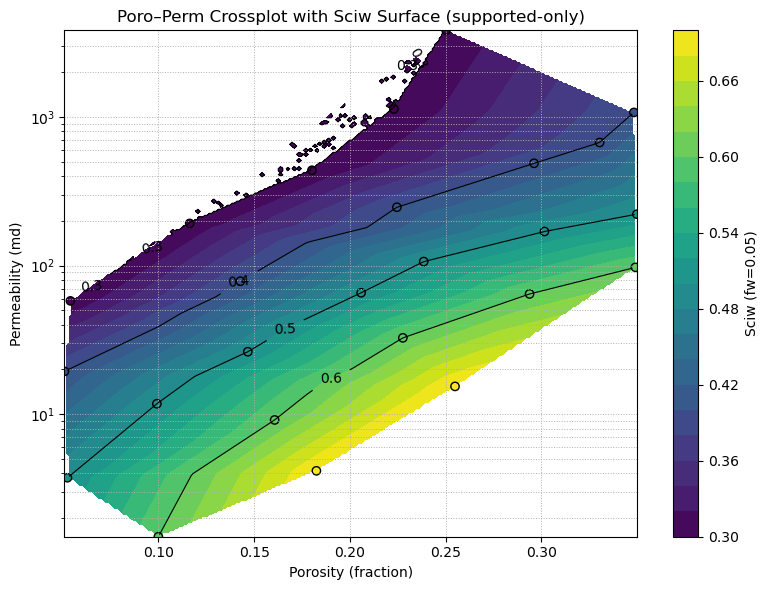

In [10]:
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay

# --- prevents duplicate plots in notebooks
plt.ioff()
plt.close("all")

# -----------------------------
# Data (phi, k_md, sciw)
# -----------------------------
data1 = np.array([
    [0.054085603,  57.89564737, 0.3],
    [0.116342412, 192.3298499,  0.3],
    [0.180155642, 438.5542724,  0.3],
    [0.222957198, 1133.638817,  0.3],
    [0.250194553, 3834.04837,   0.3],
    [0.050972763,  19.40607668, 0.4],
    [0.142801556,  78.51301122, 0.4],
    [0.224513619, 247.1702,     0.4],
    [0.296108949, 488.3328648,  0.4],
    [0.330350195, 674.2078026,  0.4],
    [0.348249027, 1074.306998,  0.4],
    [0.052529183,  3.732367815, 0.5],
    [0.09922179,  11.75002824,  0.5],
    [0.146692607, 26.31682321,  0.5],
    [0.205836576, 65.63275318,  0.5],
    [0.238521401, 106.4724761,  0.5],
    [0.30155642,  169.6570786,  0.5],
    [0.349805447, 221.9747124,  0.5],
    [0.1,         1.496570831,  0.6],
    [0.160700389, 9.143016303,  0.6],
    [0.227626459, 32.63012046,  0.6],
    [0.293774319, 64.46715747,  0.6],
    [0.349027237, 97.34795849,  0.6],
    [0.182490272, 4.156014392,  0.7],
    [0.254863813, 15.37341773,  0.7],
], dtype=float)

phi  = data1[:, 0]
k_md = data1[:, 1]
sciw = data1[:, 2]

X = np.column_stack([phi, np.log10(k_md)])
interp = LinearNDInterpolator(X, sciw)
tri = Delaunay(X)

phi_g  = np.linspace(phi.min(),  phi.max(),  250)
logk_g = np.linspace(np.log10(k_md).min(), np.log10(k_md).max(), 250)
PHI, LOGK = np.meshgrid(phi_g, logk_g)

Xg = np.column_stack([PHI.ravel(), LOGK.ravel()])
Z  = interp(Xg)

inside = tri.find_simplex(Xg) >= 0
Z = np.asarray(Z, dtype=float)
Z[~inside] = np.nan
Z = Z.reshape(PHI.shape)

K = 10**LOGK

# -----------------------------
# Plot (single figure)
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 6))

levels = np.linspace(0.3, 0.7, 21)
cf = ax.contourf(PHI, K, Z, levels=levels)
cb = fig.colorbar(cf, ax=ax)
cb.set_label("Sciw (fw=0.05)")

cs = ax.contour(PHI, K, Z, levels=np.arange(0.3, 0.71, 0.1), colors="k", linewidths=0.8)
ax.clabel(cs, fmt="%.1f", inline=True)

ax.scatter(phi, k_md, c=sciw, edgecolors="k")

ax.set_yscale("log")
ax.set_xlabel("Porosity (fraction)")
ax.set_ylabel("Permeability (md)")
ax.set_title("Poro–Perm Crossplot with Sciw Surface (supported-only)")
ax.grid(True, which="both", linestyle=":", linewidth=0.7)

plt.tight_layout()
plt.show()
plt.close(fig)

In [11]:
import numpy as np
from scipy.interpolate import RBFInterpolator
from scipy.optimize import brentq, minimize_scalar

def build_gk_rbf_sciw_surface(smoothing=0.02, kernel="thin_plate_spline"):
    """
    Build extrapolating Sciw surface Sciw = f(phi, log10(k_md)) from Granberry & Keelan points.
    Returns: callable sciw_surface(phi, k_md, clip=(lo,hi))
    """
    gk_points = np.array([
        [0.054085603,  57.89564737, 0.3],
        [0.116342412, 192.3298499,  0.3],
        [0.180155642, 438.5542724,  0.3],
        [0.222957198, 1133.638817,  0.3],
        [0.250194553, 3834.04837,   0.3],

        [0.050972763,  19.40607668, 0.4],
        [0.142801556,  78.51301122, 0.4],
        [0.224513619, 247.1702,     0.4],
        [0.296108949, 488.3328648,  0.4],
        [0.330350195, 674.2078026,  0.4],
        [0.348249027, 1074.306998,  0.4],

        [0.052529183,  3.732367815, 0.5],
        [0.09922179,  11.75002824,  0.5],
        [0.146692607, 26.31682321,  0.5],
        [0.205836576, 65.63275318,  0.5],
        [0.238521401, 106.4724761,  0.5],
        [0.30155642,  169.6570786,  0.5],
        [0.349805447, 221.9747124,  0.5],

        [0.1,         1.496570831,  0.6],
        [0.160700389, 9.143016303,  0.6],
        [0.227626459, 32.63012046,  0.6],
        [0.293774319, 64.46715747,  0.6],
        [0.349027237, 97.34795849,  0.6],

        [0.182490272, 4.156014392,  0.7],
        [0.254863813, 15.37341773,  0.7],
    ], dtype=float)

    phi_train  = gk_points[:, 0]
    k_train_md = gk_points[:, 1]
    sciw_train = gk_points[:, 2]

    X_train = np.column_stack([phi_train, np.log10(k_train_md)])

    rbf = RBFInterpolator(
        X_train, sciw_train,
        kernel=kernel,
        smoothing=float(smoothing),
    )

    def sciw_surface(phi, k_md, clip=(0.2, 0.8)):
        phi = np.asarray(phi, dtype=float)
        k_md = np.asarray(k_md, dtype=float)

        out = np.full(np.broadcast(phi, k_md).shape, np.nan, dtype=float)
        phi_b = np.broadcast_to(phi, out.shape).ravel()
        k_b   = np.broadcast_to(k_md, out.shape).ravel()

        # guard: log10 needs k>0
        good = np.isfinite(phi_b) & np.isfinite(k_b) & (k_b > 0)
        if np.any(good):
            Xq = np.column_stack([phi_b[good], np.log10(k_b[good])])
            z = rbf(Xq)
            if clip is not None:
                z = np.clip(z, clip[0], clip[1])
            out.ravel()[good] = z

        return out

    # expose training data for diagnostics if needed
    sciw_surface._train = dict(phi=phi_train, logk=np.log10(k_train_md), sciw=sciw_train)
    return sciw_surface


def invert_k_from_phi_sw_rbf(phi, sw, sciw_surface,
                             kmin_md=1e-3, kmax_md=1e4,
                             sw_clip=(0.2, 0.8),
                             n_scan=60):
    """
    Solve Sciw(phi,k)=Sw for k. Extrapolating because sciw_surface is RBF.
    Returns (k_pred_md, flags).
    flags:
      1 Sw clipped to sw_clip
      2 no bracket -> minimization
      4 hit bound
      16 non-finite
    """
    phi = np.asarray(phi, dtype=float)
    sw  = np.asarray(sw, dtype=float)

    shape = np.broadcast(phi, sw).shape
    phi_b = np.broadcast_to(phi, shape).ravel()
    sw_b  = np.broadcast_to(sw,  shape).ravel()

    flags = np.zeros(phi_b.shape, dtype=np.int32)

    # clip Sw if requested
    sw_t = sw_b.copy()
    if sw_clip is not None:
        lo, hi = sw_clip
        clipped = (sw_t < lo) | (sw_t > hi)
        flags[clipped] |= 1
        sw_t = np.clip(sw_t, lo, hi)

    umin, umax = np.log10(kmin_md), np.log10(kmax_md)
    ugrid = np.linspace(umin, umax, int(n_scan))

    def f_u(ph, sw_target, u):
        k = 10**u
        z = sciw_surface(np.array([ph]), np.array([k]), clip=sw_clip)[0]
        return float(z - sw_target)

    k_out = np.full(phi_b.shape, np.nan, dtype=float)

    for i in range(phi_b.size):
        ph = phi_b[i]
        swt = sw_t[i]
        if not (np.isfinite(ph) and np.isfinite(swt)):
            flags[i] |= 16
            continue

        fgrid = np.array([f_u(ph, swt, u) for u in ugrid], dtype=float)
        sign = np.sign(fgrid)
        sign[np.isnan(sign)] = 0.0
        idx = np.where(sign[:-1] * sign[1:] < 0)[0]

        if idx.size:
            j = int(idx[0])
            a, b = float(ugrid[j]), float(ugrid[j+1])
            try:
                u_star = brentq(lambda u: f_u(ph, swt, u), a, b, maxiter=200)
            except Exception:
                flags[i] |= 2
                res = minimize_scalar(lambda u: abs(f_u(ph, swt, u)),
                                      bounds=(umin, umax), method="bounded")
                u_star = float(res.x)
        else:
            flags[i] |= 2
            res = minimize_scalar(lambda u: abs(f_u(ph, swt, u)),
                                  bounds=(umin, umax), method="bounded")
            u_star = float(res.x)

        if (u_star <= umin + 1e-10) or (u_star >= umax - 1e-10):
            flags[i] |= 4

        k_star = 10**u_star
        if np.isfinite(k_star):
            k_out[i] = k_star
        else:
            flags[i] |= 16

    return k_out.reshape(shape), flags.reshape(shape)


# -----------------------------
# APPLY TO YOUR DATAFRAME SAFELY
# -----------------------------
# data must already exist
# Choose your column names here:
#phi_col = phi_log
#sw_col  = sw_log   # or "Sw_log" etc.

sciw_surface = build_gk_rbf_sciw_surface(smoothing=0.02)



mask = merged_df["MPHI"] > 0.1

k_pred, flags = invert_k_from_phi_sw_rbf(
    merged_df.loc[mask, "PHIT"].to_numpy(),
    merged_df.loc[mask, "SW_PROXY"].to_numpy(),
    sciw_surface,
    kmin_md=1e-3, kmax_md=1e4,
    sw_clip=(0.2, 0.8),
    n_scan=80
)


# initialize columns
merged_df["k_pred_md"] = np.nan
merged_df["flags"] = 0

# assign only where mask is True
merged_df.loc[mask, "k_pred_md"] = k_pred
merged_df.loc[mask, "flags"] = flags

print("k_pred_md:", merged_df["k_pred_md"].head())
print("flags:", merged_df["flags"].head())


k_pred_md: DEPTH
5500.0   NaN
5500.5   NaN
5501.0   NaN
5501.5   NaN
5502.0   NaN
Name: k_pred_md, dtype: float64
flags: DEPTH
5500.0    0
5500.5    0
5501.0    0
5501.5    0
5502.0    0
Name: flags, dtype: int64


## Process and Rename log curves for plots and analysis. The plots want a DEPT, Rxo....

In [12]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- prevents duplicate plots in notebooks
plt.ioff()
plt.close("all")



# -----------------------------
# Helpers
# -----------------------------
def is_ohmm_curve(curve_name: str, units_map: dict) -> bool:
    u = (units_map.get(curve_name, "") or "").strip().upper().replace(" ", "")
    return any(tok in u for tok in ["OHMM", "OHM.M", "OHM-M", "OHM/M", "MD", "MS"])

def nice_label(mnemonic, units_map):
    u = (units_map.get(mnemonic, "") or "").strip() if isinstance(units_map, dict) else ""
    return f"{mnemonic}\n[{u}]" if u else mnemonic

def first_present(cols, candidates):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

def add_tops(ax, top_depth, bottom_depth):
    if "tops_depths" in globals() and "tops" in globals():
        for d in tops_depths:
            if top_depth <= d <= bottom_depth:
                ax.axhline(d, color="red", linewidth=2.0)

def add_tops_labels(ax, top_depth, bottom_depth):
    """
    Draw top names in the GR track, right-justified.
    Uses x in axes fraction (0..1) and y in data (depth).
    """
    if "tops_depths" in globals() and "tops" in globals():
        for d, nm in zip(tops_depths, tops):
            if top_depth <= d <= bottom_depth:
                ax.text(
                    0.985, d, str(nm),
                    transform=ax.get_yaxis_transform(),
                    ha="right", va="center",
                    color="black", fontsize=20,
                    zorder=50,
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.65, pad=1.5)
                )

def setup_porosity_axis(a):
    ticks = [-0.15, 0.00, 0.15, 0.30, 0.45]
    a.set_xlim(-0.15, 0.45)
    a.invert_xaxis()
    a.set_xticks(ticks)
    a.grid(True, axis="x", linestyle="--", linewidth=0.7, alpha=0.8)

def ensure_depth_column(df, depth_col="DEPT"):
    """
    Return a copy with a numeric DEPT column guaranteed.
    If DEPT doesn't exist, it is created from index.
    """
    d = df.copy()
    if depth_col not in d.columns:
        d[depth_col] = d.index
    d[depth_col] = pd.to_numeric(d[depth_col], errors="coerce")
    d = d.dropna(subset=[depth_col])
    return d

def df_depth_limits_any(df, depth_col="DEPT"):
    """
    Return (min_depth, max_depth) from either DEPT column or index.
    Prefers DEPT if present.
    """
    d = df.copy()
    if depth_col in d.columns:
        dep = pd.to_numeric(d[depth_col], errors="coerce").to_numpy()
    else:
        dep = pd.to_numeric(pd.Index(d.index), errors="coerce").to_numpy()
    dep = dep[np.isfinite(dep)]
    if dep.size == 0:
        raise ValueError("No finite depths found in DEPT or index.")
    return float(dep.min()), float(dep.max())

def curve_depth_limits_any(df, curve, depth_col="DEPT"):
    """
    Return (top_depth, base_depth) where df[curve] is finite.
    Uses DEPT if present, else index.
    """
    d = df.copy()
    if curve not in d.columns:
        raise ValueError(f"{curve} not present in df.")
    d = ensure_depth_column(d, depth_col=depth_col)
    vals = pd.to_numeric(d[curve], errors="coerce").to_numpy()
    dep  = d[depth_col].to_numpy(dtype=float)
    m = np.isfinite(vals) & np.isfinite(dep)
    if not np.any(m):
        raise ValueError(f"No finite values found for {curve}.")
    return float(dep[m].min()), float(dep[m].max())

def build_units_map_for_df(df, base_units=None):
    u = dict(base_units) if isinstance(base_units, dict) else {}
    for c in df.columns:
        if c not in u:
            u[c] = ""
    for c in ["PHIT_NMR", "PHIE_NMR", "FFI", "BVIE", "BVI_E", "CBW"]:
        if c in df.columns and not u.get(c, ""):
            u[c] = "v/v"
    return u

def slice_zone_df(df, top_depth, bottom_depth, depth_col="DEPT"):
    """
    Slice by depth using DEPT column (created if needed).
    Returns sorted, reset-index df with numeric DEPT.
    """
    top_depth, bottom_depth = (top_depth, bottom_depth) if top_depth <= bottom_depth else (bottom_depth, top_depth)
    d = ensure_depth_column(df, depth_col=depth_col)
    z = d.loc[(d[depth_col] >= top_depth) & (d[depth_col] <= bottom_depth)].copy()
    z = z.sort_values(depth_col).reset_index(drop=True)
    return z

# -----------------------------
# Main plot function (works with DEPT column OR index)
# -----------------------------
def plot_zone_template_from_df(df_in, units_map, top_depth, bottom_depth, title=None, depth_col="DEPT"):
    if df_in is None or df_in.empty:
        raise ValueError("merged_df is empty.")

    top_depth, bottom_depth = (top_depth, bottom_depth) if top_depth <= bottom_depth else (bottom_depth, top_depth)

    # Slice using DEPT column, regardless of whether original df had it
    z = slice_zone_df(df_in, top_depth, bottom_depth, depth_col=depth_col)
    if z.empty:
        raise ValueError(f"No data in zone {top_depth}–{bottom_depth}.")

    depth = z[depth_col].to_numpy(dtype=float)

    # Candidate lists
    gr_cands  = ["GR", "SGR", "HGR", "HSGR"]
    cgr_cands = ["CGR", "HCGR"]

    cali_cands = ["CALI","CALS","HCAL","CAL","CALIPER","HD1_PPC1","HD2_PPC1"]
    bs_cands   = ["BS","BITSIZE","BIT","BIT_SIZE"]
    dcal_cands = ["DCAL","DCALI","D_CAL","CALD"]

    rhob_cands = ["RHOB", "RHOZ"]
    drho_cands = ["DRHO", "HDRA", "HDRH", "DROH", "DRH", "RHOC"]
    tnph_cands = ["TNPH", "NPHI", "NPOR", "CNL"]
    phit_cands = ["PHIT"]
    
    tcmr_cands = ["PHIT_NMR", "TCMR", "MPHIS"]
    cmrp_cands = ["PHIE_NMR", "CMRP_3MS", "CMRP3MS", "CMRP", "MPHI"]
    bvi_cands  = ["MBVI","BVIE", "BVI_E"]
    ffi_cands  = ["MFFI","FFI"]

    rxo_cands  = ["RXOZ", "Rxo", "RXO", "RxoZ"]
    at90_cands = ["AT90", "AF90", "AO90", "ILD", "RT"]
    at60_cands = ["AT60", "AF60", "AO60"]
    at30_cands = ["AT30", "AF30", "AO30"]
    at20_cands = ["AT20", "AF20", "AO20"]
    at10_cands = ["AT10", "AF10", "AO10"]

    perm_cands = ["MPERM", "PERM", "CPERM"]
    pred_cands = ["k_pred_md"]


    
    # Pick curves
    gr   = first_present(z.columns, gr_cands)
    cgr  = first_present(z.columns, cgr_cands)

    cali = first_present(z.columns, cali_cands)
    bs   = first_present(z.columns, bs_cands)
    dcal = first_present(z.columns, dcal_cands)

    rhob = first_present(z.columns, rhob_cands)
    drho = first_present(z.columns, drho_cands)
    tnph = first_present(z.columns, tnph_cands)
    phit = first_present(z.columns, phit_cands)
    
    
    tcmr = first_present(z.columns, tcmr_cands)
    cmrp = first_present(z.columns, cmrp_cands)
    bvie = first_present(z.columns, bvi_cands)
    ffi  = first_present(z.columns, ffi_cands)


    rxo  = first_present(z.columns, rxo_cands)
    at90 = first_present(z.columns, at90_cands)
    at60 = first_present(z.columns, at60_cands)
    at30 = first_present(z.columns, at30_cands)
    at20 = first_present(z.columns, at20_cands)
    at10 = first_present(z.columns, at10_cands)

    perm = first_present(z.columns, perm_cands)
    pred = first_present(z.columns, pred_cands)


    # -----------------------------
    # Create 4 tracks
    # -----------------------------
    fig, ax = plt.subplots(
        nrows=1, ncols=4, figsize=(18, 20), sharey=True,
        gridspec_kw={"width_ratios": [1.8, 1.9, 1.7, 1.7]}
    )

    if title is None:
        title = f"Zone Template Plot — {top_depth:g}–{bottom_depth:g} ft"
    fig.suptitle(title, fontsize=18, color="blue", y=0.995)
    fig.subplots_adjust(top=0.80, wspace=0.24)

    # Common Y formatting
    for a in ax:
        a.set_ylim(top_depth, bottom_depth)
        a.invert_yaxis()
        a.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        add_tops(a, top_depth, bottom_depth)

    add_tops_labels(ax[0], top_depth, bottom_depth)

    # ==========================================================
    # Track 1: GR/CGR fills + Hole condition
    # ==========================================================
    ax[0].set_title("GR/CGR + Hole", fontsize=14, color="green")
    x_left_gr, x_right_gr = 0.0, 200.0
    ax[0].set_xlim(x_left_gr, x_right_gr)
    ax[0].grid(True, axis="x", linestyle="--", linewidth=0.7, alpha=0.6)

    a_fill_gr = ax[0].twiny()
    a_fill_gr.set_xlim(x_left_gr, x_right_gr)
    a_fill_gr.spines["top"].set_visible(False)
    a_fill_gr.get_xaxis().set_visible(False)
    a_fill_gr.grid(False)

    gr_vals  = pd.to_numeric(z[gr], errors="coerce").to_numpy() if gr else None
    cgr_vals = pd.to_numeric(z[cgr], errors="coerce").to_numpy() if cgr else None

    if cgr_vals is not None:
        a_fill_gr.fill_betweenx(depth, 0.0, cgr_vals, where=np.isfinite(cgr_vals), facecolor="green", alpha=1.0)

    if (gr_vals is not None) and (cgr_vals is not None):
        a_fill_gr.fill_betweenx(
            depth, cgr_vals, gr_vals,
            where=np.isfinite(gr_vals) & np.isfinite(cgr_vals) & (gr_vals >= cgr_vals),
            facecolor="magenta", alpha=1.0
        )

    if (gr_vals is not None) and (cgr_vals is None):
        a_fill_gr.fill_betweenx(depth, 0.0, gr_vals, where=np.isfinite(gr_vals), facecolor="green", alpha=0.25)

    if gr:
        a = ax[0].twiny()
        a.set_xlim(x_left_gr, x_right_gr)
        a.plot(gr_vals, depth, color="green", linewidth=2.5)
        a.set_xlabel(nice_label(gr, units_map), color="green")
        a.tick_params(axis="x", colors="green")
        a.spines["top"].set_position(("outward", 0))
        a.grid(False)

    if cgr:
        a = ax[0].twiny()
        a.set_xlim(x_left_gr, x_right_gr)
        a.plot(cgr_vals, depth, color="magenta", linewidth=2.5)
        a.set_xlabel(nice_label(cgr, units_map), color="magenta")
        a.tick_params(axis="x", colors="magenta")
        a.spines["top"].set_position(("outward", 35))
        a.grid(False)

    cali_min, cali_max = 5.0, 25.0
    dcal_min, dcal_max = -2.0, 2.0

    if cali:
        a = ax[0].twiny()
        a.set_xlim(cali_min, cali_max)
        a.plot(pd.to_numeric(z[cali], errors="coerce").to_numpy(), depth, color="k", linewidth=1, linestyle="--")
        a.set_xlabel(nice_label(cali, units_map), color="k")
        a.tick_params(axis="x", colors="k")
        a.spines["top"].set_position(("outward", 80))
        a.grid(False)

    if bs:
        a = ax[0].twiny()
        a.set_xlim(cali_min, cali_max)
        a.plot(pd.to_numeric(z[bs], errors="coerce").to_numpy(), depth, color="black", linewidth=1.1, linestyle="--")
        a.set_xlabel(nice_label(bs, units_map), color="black")
        a.tick_params(axis="x", colors="black")
        a.spines["top"].set_position(("outward", 115))
        a.grid(False)

    if cali and bs:
        cali_vals_h = pd.to_numeric(z[cali], errors="coerce").to_numpy()
        bs_vals_h   = pd.to_numeric(z[bs], errors="coerce").to_numpy()
        a_fill_h = ax[0].twiny()
        a_fill_h.set_xlim(cali_min, cali_max)
        a_fill_h.spines["top"].set_visible(False)
        a_fill_h.get_xaxis().set_visible(False)
        a_fill_h.grid(False)

        a_fill_h.fill_betweenx(
            depth, bs_vals_h, cali_vals_h,
            where=np.isfinite(cali_vals_h) & np.isfinite(bs_vals_h) & (cali_vals_h > bs_vals_h),
            facecolor="yellow", alpha=0.25
        )

    if dcal:
        DC = pd.to_numeric(z[dcal], errors="coerce").to_numpy()

        a_fill_d = ax[0].twiny()
        a_fill_d.set_xlim(dcal_min, dcal_max)
        a_fill_d.spines["top"].set_visible(False)
        a_fill_d.get_xaxis().set_visible(False)
        a_fill_d.grid(False)

        a_fill_d.fill_betweenx(depth, 0.0, np.clip(DC, 0.0, None),
                               where=np.isfinite(DC) & (DC > 0), facecolor="yellow", alpha=0.45)
        a_fill_d.fill_betweenx(depth, np.clip(DC, None, 0.0), 0.0,
                               where=np.isfinite(DC) & (DC < 0), facecolor="saddlebrown", alpha=0.45)

        a = ax[0].twiny()
        a.set_xlim(dcal_min, dcal_max)
        a.plot(DC, depth, color="purple", linewidth=1.4, linestyle="--")
        a.set_xlabel(nice_label(dcal, units_map), color="purple")
        a.tick_params(axis="x", colors="purple")
        a.spines["top"].set_position(("outward", 150))
        a.grid(False)

    # ==========================================================
    # Track 2: RHOB / TNPH / PHIT / PHIE / DRHO
    # ==========================================================
    ax[1].set_title("RHOB / TNPH / DRHO", fontsize=14, color="blue")
    overlay_done = False

    if tnph:
        a = ax[1].twiny()
        setup_porosity_axis(a)
        a.plot(pd.to_numeric(z[tnph], errors="coerce").to_numpy(), depth, color="green", linewidth=1, linestyle="--")
        a.set_xlabel(nice_label(tnph, units_map), color="green")
        a.tick_params(axis="x", colors="green")
        a.spines["top"].set_position(("outward", 0))
        overlay_done = True


    if rhob:
        a = ax[1].twiny()
        a.set_xlim(1.95, 2.95)
        a.plot(pd.to_numeric(z[rhob], errors="coerce").to_numpy(), depth, color="red", linewidth=1.8)
        a.set_xlabel(nice_label(rhob, units_map), color="red")
        a.tick_params(axis="x", colors="red")
        a.spines["top"].set_position(("outward", 35))
        a.grid(False)
        overlay_done = True

    if phit:
        a = ax[1].twiny()
        setup_porosity_axis(a)
        a.plot(pd.to_numeric(z[phit], errors="coerce").to_numpy(), depth, color="k", linewidth=1, linestyle="-")
        a.set_xlabel(nice_label(phit, units_map), color="k")
        a.tick_params(axis="x", colors="k")
        a.spines["top"].set_position(("outward", 70))
        overlay_done = True



    
    if drho:
        a = ax[1].twiny()
        a.set_xlim(-0.15, 0.15)
        a.plot(pd.to_numeric(z[drho], errors="coerce").to_numpy(), depth, color="purple", linewidth=0.7, linestyle="--")
        a.set_xlabel(nice_label(drho, units_map), color="purple")
        a.tick_params(axis="x", colors="purple")
        a.spines["top"].set_position(("outward", 105))
        a.grid(False)
        overlay_done = True

    if not overlay_done:
        ax[1].text(0.5, 0.5, "No RHOB / TNPH / DRHO", transform=ax[1].transAxes, ha="center", va="center")

    # ==========================================================
    # Track 3: Resistivity (log)
    # ==========================================================
    ax[2].set_title("Resistivity (log)", fontsize=14, color="blue")
    ax[2].set_xscale("log")
    ax[2].set_xlim(0.2, 2000)

    ax[2].xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
    ax[2].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1))
    ax[2].xaxis.set_minor_formatter(NullFormatter())

    ax[2].grid(which="major", axis="x", linestyle="-", linewidth=2.2, alpha=1.0)
    ax[2].grid(which="minor", axis="x", linestyle=":", linewidth=0.7, alpha=0.9)

    res_curves = [
        ("RXO",  rxo,  "blue",   "-",         1.0,   0),
        ("AT10", at10, "green",  "--",        1.0,  35),
        #("AT20", at20, "orange", "-.",        1.0,  70),
        ("AT30", at30, "red",    ":",         1.0, 70),
        #("AT60", at60, "purple", (0, (5, 2)), 1.0, 140),
        ("AT90", at90, "black",  "--",        2.8, 105),
        ("MPERM", perm, "black",  "-",        2, 140),
        ("k_pred_md", pred, "magenta",  "-",  3, 175),

        
    ]

    any_res = False
    for _, c, color, ls, lw, off in res_curves:
        if c:
            a = ax[2].twiny()
            a.set_xscale("log")
            a.set_xlim(0.2, 2000)
            a.plot(pd.to_numeric(z[c], errors="coerce").to_numpy(), depth, color=color, linestyle=ls, linewidth=lw)
            a.set_xlabel(nice_label(c, units_map), color=color)
            a.tick_params(axis="x", colors=color)
            a.spines["top"].set_position(("outward", off))
            a.grid(False)
            any_res = True

    if not any_res:
        ax[2].text(0.5, 0.5, "No resistivity curves", transform=ax[2].transAxes, ha="center", va="center")

    # ==========================================================
    # Track 4: NMR Partition
    # ==========================================================
    ax[3].set_title("NMR Partition", fontsize=14, color="blue")
    x_left, x_right = 0.0, 0.30
    ax[3].set_xlim(x_left, x_right)
    ax[3].invert_xaxis()
    ax[3].grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

    phit = pd.to_numeric(z[tcmr], errors="coerce").to_numpy() if tcmr else None
    phie = pd.to_numeric(z[cmrp], errors="coerce").to_numpy() if cmrp else None

    bvie = pd.to_numeric(z[bvie], errors="coerce").to_numpy() if bvie else None

    if bvie is None and (phie is not None) and ffi:
        ff = pd.to_numeric(z[ffi], errors="coerce").to_numpy()
        ff_clip = np.where(np.isfinite(ff) & np.isfinite(phie), np.clip(ff, 0.0, phie), np.nan)
        bvie = np.where(np.isfinite(phie) & np.isfinite(ff_clip), np.maximum(phie - ff_clip, 0.0), np.nan)

    a_fill = ax[3].twiny()
    a_fill.set_xlim(x_left, x_right)
    a_fill.invert_xaxis()
    a_fill.spines["top"].set_visible(False)
    a_fill.get_xaxis().set_visible(False)
    a_fill.grid(False)

    any_nmr = False

    if bvie is not None:
        a_fill.fill_betweenx(depth, 0.0, bvie, where=np.isfinite(bvie), facecolor="blue", alpha=1.0)
        any_nmr = True

    if (phie is not None) and (bvie is not None):
        a_fill.fill_betweenx(depth, bvie, phie,
                             where=np.isfinite(phie) & np.isfinite(bvie) & (phie >= bvie),
                             facecolor="yellow", alpha=1.0)
        any_nmr = True

    if (phit is not None) and (phie is not None):
        a_fill.fill_betweenx(depth, phie, phit,
                             where=np.isfinite(phit) & np.isfinite(phie) & (phit >= phie),
                             facecolor="gray", alpha=0.65)
        any_nmr = True


    
    nmr_curves = [
        ("CMRP", "k", 35,  1, "-"),
        ("BVIE", "k", 70,  1, "-."),
    ]
    
    for curve_name, color, off, lw, ls in nmr_curves:
        if curve_name in z.columns:
            a = ax[3].twiny()
            a.set_xlim(x_left, x_right)
            a.invert_xaxis()
    
            values = pd.to_numeric(z[curve_name], errors="coerce").to_numpy()
            a.plot(values, depth, color=color, linewidth=lw, linestyle=ls)
    
            a.set_xlabel(nice_label(curve_name, units_map), color=color)
            a.tick_params(axis="x", colors=color)
            a.spines["top"].set_position(("outward", off))
            a.grid(False)
        
    if not any_nmr:
        ax[3].text(0.5, 0.5, "No NMR curves", transform=ax[3].transAxes, ha="center", va="center")

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    return fig

# -----------------------------
# Units map (includes computed curves)
# -----------------------------
_base_units = combined_units_map if "combined_units_map" in globals() else {}
_units = build_units_map_for_df(merged_df, base_units=_base_units)

# -----------------------------
# Slider defaults (prefer PHIT_NMR coverage if usable)
# -----------------------------
df_min, df_max = df_depth_limits_any(merged_df, depth_col="DEPT")

preferred_curve = "PHIT_NMR"
if preferred_curve in merged_df.columns:
    try:
        slider_min, slider_max = curve_depth_limits_any(merged_df, preferred_curve, depth_col="DEPT")
        print(f"Auto zone from {preferred_curve}: {slider_min:.1f} – {slider_max:.1f} ft")
    except Exception as e:
        slider_min, slider_max = df_min, df_max
        print(f"⚠️ {preferred_curve} present but unusable ({e}). Using full range.")
else:
    slider_min, slider_max = df_min, df_max
    print(f" {preferred_curve} not present. Using full range: {slider_min:.1f} – {slider_max:.1f} ft")

# -----------------------------
# Interactive widget + callback (SINGLE UI)
# -----------------------------
int_range_slider = widgets.FloatRangeSlider(
    value=[slider_min, slider_max],
    min=df_min,
    max=df_max,
    step=0.5,                 # <-- change to 1.0 if you truly want 1-ft increments
    description="Depths:",
    continuous_update=False,
    readout=True,
    readout_format=".1f",
    layout=widgets.Layout(width="900px")
)

save_btn = widgets.Button(description="Save current plot", button_style="success", icon="save")
save_status = widgets.HTML(value="")
plot_out = widgets.Output()

# Global state for downstream cells
analysis_depth_range = None  # (top, base) with top <= base
analysis_df = None           # sliced zone df with numeric DEPT column

def _make_title():
    if "well_name_cleaned" in globals() and "file_directory" in globals():
        return f"Zone Plot — {well_name_cleaned} — {file_directory}"
    return "Zone Plot — merged_df"

def _make_plot(top_d, bot_d):
    return plot_zone_template_from_df(
        merged_df,
        _units,
        top_d,
        bot_d,
        title=_make_title(),
        depth_col="DEPT"
    )

def _redraw(*_):
    global analysis_depth_range, analysis_df

    top_d, bot_d = map(float, int_range_slider.value)
    top_d, bot_d = (top_d, bot_d) if top_d <= bot_d else (bot_d, top_d)

    analysis_depth_range = (top_d, bot_d)
    analysis_df = slice_zone_df(merged_df, top_d, bot_d, depth_col="DEPT")

    with plot_out:
        clear_output(wait=True)
        fig = _make_plot(top_d, bot_d)
        plt.show()
        plt.close(fig)

def on_save_clicked(_):
    top_d, bot_d = map(float, int_range_slider.value)
    top_d, bot_d = (top_d, bot_d) if top_d <= bot_d else (bot_d, top_d)

    fig = _make_plot(top_d, bot_d)

    plots_dir = os.path.join(file_directory, "plots") if "file_directory" in globals() else "plots"
    os.makedirs(plots_dir, exist_ok=True)

    well = well_name_cleaned if "well_name_cleaned" in globals() else "unknown_well"
    folder = file_directory if "file_directory" in globals() else "unknown_folder"
    fname = f"ZonePlot_{well}_{folder}_{int(top_d)}-{int(bot_d)}ft.png"
    outfile = os.path.join(plots_dir, fname)

    fig.savefig(outfile, dpi=300, bbox_inches="tight", facecolor="white")
    plt.close(fig)

    save_status.value = f"<b> Saved:</b> <code>{outfile}</code>"

int_range_slider.observe(_redraw, names="value")
save_btn.on_click(on_save_clicked)

# Initial draw + UI
_redraw()
display(widgets.VBox([widgets.HBox([int_range_slider, save_btn]), save_status, plot_out]))

print("analysis_depth_range =", analysis_depth_range)
print("analysis_df shape    =", None if analysis_df is None else analysis_df.shape)
print("analysis_df has DEPT  =", None if analysis_df is None else ("DEPT" in analysis_df.columns))


 PHIT_NMR not present. Using full range: 5500.0 – 7500.0 ft


analysis_depth_range = (5500.0, 7500.0)
analysis_df shape    = (4001, 28)
analysis_df has DEPT  = True
